In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

from math import sqrt
from sklearn.metrics import mean_squared_error

from joblib import Parallel, delayed

import multiprocessing

In [2]:
df = pickle.load( open( "seattle_data.pkl", "rb" ) )

In [3]:
df.head()

,DATE,SHORTDATE,Temperature,Precipitation,Humidity,Condition,Pressure,Visibility,WindDirection,WindSpeed,DEMAND
0,2015-07-02 00:53:00,2015-07-02,74.0,0.0,48.0,CLR,29.94,10.0,Calm,0.0,1282.0
1,2015-07-02 01:53:00,2015-07-02,72.0,0.0,53.0,CLR,29.94,10.0,Variable,3.0,1277.0
2,2015-07-02 02:53:00,2015-07-02,70.0,0.0,55.0,CLR,29.95,10.0,North,3.0,1226.0
3,2015-07-02 03:53:00,2015-07-02,68.0,0.0,59.0,CLR,29.96,10.0,Calm,0.0,1186.0
4,2015-07-02 04:53:00,2015-07-02,68.0,0.0,61.0,CLR,29.97,10.0,West,3.0,1157.0


### Let's look at prophet during the pandemic

In [37]:
df_nonpandemic = df.loc[df.DATE < '2020-03-01']

In [4]:
from fbprophet import Prophet

In [8]:
train_df = df.iloc[:int(.66*len(df))]

In [17]:
df.iloc[:int(.66*len(df))]

,DATE,SHORTDATE,Temperature,Precipitation,Humidity,Condition,Pressure,Visibility,WindDirection,WindSpeed,DEMAND
0,2015-07-02 00:53:00,2015-07-02,74.0,0.00,48.0,CLR,29.94,10.0,Calm,0.0,1282.0
1,2015-07-02 01:53:00,2015-07-02,72.0,0.00,53.0,CLR,29.94,10.0,Variable,3.0,1277.0
2,2015-07-02 02:53:00,2015-07-02,70.0,0.00,55.0,CLR,29.95,10.0,North,3.0,1226.0
3,2015-07-02 03:53:00,2015-07-02,68.0,0.00,59.0,CLR,29.96,10.0,Calm,0.0,1186.0
4,2015-07-02 04:53:00,2015-07-02,68.0,0.00,61.0,CLR,29.97,10.0,West,3.0,1157.0
...,...,...,...,...,...,...,...,...,...,...,...
31294,2019-04-04 22:53:00,2019-04-04,53.0,0.02,80.0,OVC,29.77,9.0,Calm,0.0,1042.0
31295,2019-04-04 23:53:00,2019-04-04,53.0,0.02,83.0,BKN,29.77,10.0,East,5.0,1037.0
31296,2019-04-05 00:53:00,2019-04-05,52.0,0.03,86.0,FEW,29.76,6.0,South,6.0,1041.0
31297,2019-04-05 01:53:00,2019-04-05,52.0,0.02,86.0,OVC,29.74,10.0,South,7.0,1048.0


In [9]:
int(.66*len(df))

31299

In [16]:
len(df) - int(.66*len(df))

16125

In [18]:
test_data = df.DEMAND.iloc[31299:]

In [22]:
test_data_dates = df.DATE.iloc[31299:]

In [11]:
prophet_df = train_df.copy()

In [12]:
prophet_df = prophet_df[['DATE', 'DEMAND']].rename(columns={'DATE':'ds', 'DEMAND':'y'})

In [13]:
prophet_df

,ds,y
0,2015-07-02 00:53:00,1282.0
1,2015-07-02 01:53:00,1277.0
2,2015-07-02 02:53:00,1226.0
3,2015-07-02 03:53:00,1186.0
4,2015-07-02 04:53:00,1157.0
...,...,...
31294,2019-04-04 22:53:00,1042.0
31295,2019-04-04 23:53:00,1037.0
31296,2019-04-05 00:53:00,1041.0
31297,2019-04-05 01:53:00,1048.0


In [14]:
model = Prophet()

In [15]:
model.fit(prophet_df)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [20]:
prophet_df

,ds,y
0,2015-07-02 00:53:00,1282.0
1,2015-07-02 01:53:00,1277.0
2,2015-07-02 02:53:00,1226.0
3,2015-07-02 03:53:00,1186.0
4,2015-07-02 04:53:00,1157.0
...,...,...
31294,2019-04-04 22:53:00,1042.0
31295,2019-04-04 23:53:00,1037.0
31296,2019-04-05 00:53:00,1041.0
31297,2019-04-05 01:53:00,1048.0


In [21]:
future = list()
for i in range(1, 24):
    date = '2021-03-06 %02d:53:00' % i
    print(date)

2021-03-06 01:53:00
2021-03-06 02:53:00
2021-03-06 03:53:00
2021-03-06 04:53:00
2021-03-06 05:53:00
2021-03-06 06:53:00
2021-03-06 07:53:00
2021-03-06 08:53:00
2021-03-06 09:53:00
2021-03-06 10:53:00
2021-03-06 11:53:00
2021-03-06 12:53:00
2021-03-06 13:53:00
2021-03-06 14:53:00
2021-03-06 15:53:00
2021-03-06 16:53:00
2021-03-06 17:53:00
2021-03-06 18:53:00
2021-03-06 19:53:00
2021-03-06 20:53:00
2021-03-06 21:53:00
2021-03-06 22:53:00
2021-03-06 23:53:00


In [26]:
future = pd.DataFrame(test_data_dates)

In [28]:
future.rename(columns={'DATE':'ds'}, inplace=True)

In [31]:
forecast = model.predict(future)

In [32]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

                   ds         yhat   yhat_lower   yhat_upper
0 2019-04-05 03:53:00  1173.992116  1080.646475  1279.912700
1 2019-04-05 04:53:00  1157.105034  1054.113601  1259.142990
2 2019-04-05 05:53:00  1108.524115  1009.417815  1207.904477
3 2019-04-05 06:53:00  1038.169348   937.362267  1138.565172
4 2019-04-05 07:53:00   963.390624   866.652234  1064.483265


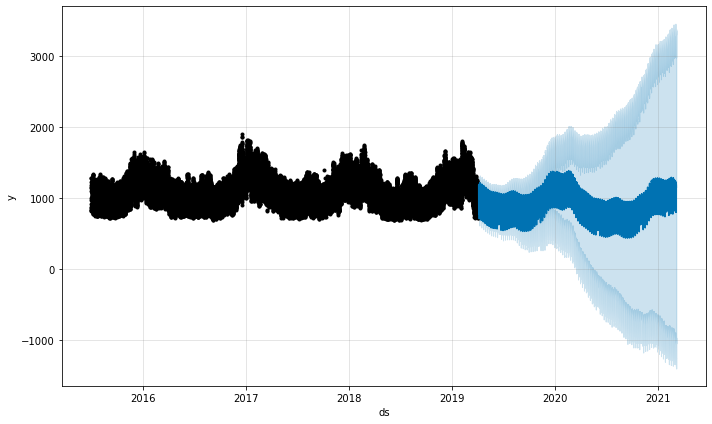

In [35]:
model.plot(forecast)
plt.show()

## Evaluate model performance

In [39]:
from sklearn.metrics import mean_absolute_error

In [40]:
y_true = test_data.values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 98.835


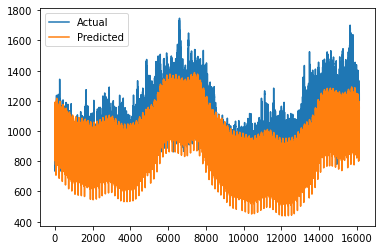

In [42]:
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

### non pandemic

In [43]:
df.head()

,DATE,SHORTDATE,Temperature,Precipitation,Humidity,Condition,Pressure,Visibility,WindDirection,WindSpeed,DEMAND
0,2015-07-02 00:53:00,2015-07-02,74.0,0.0,48.0,CLR,29.94,10.0,Calm,0.0,1282.0
1,2015-07-02 01:53:00,2015-07-02,72.0,0.0,53.0,CLR,29.94,10.0,Variable,3.0,1277.0
2,2015-07-02 02:53:00,2015-07-02,70.0,0.0,55.0,CLR,29.95,10.0,North,3.0,1226.0
3,2015-07-02 03:53:00,2015-07-02,68.0,0.0,59.0,CLR,29.96,10.0,Calm,0.0,1186.0
4,2015-07-02 04:53:00,2015-07-02,68.0,0.0,61.0,CLR,29.97,10.0,West,3.0,1157.0


In [44]:
df_nonpandemic

,DATE,SHORTDATE,Temperature,Precipitation,Humidity,Condition,Pressure,Visibility,WindDirection,WindSpeed,DEMAND
0,2015-07-02 00:53:00,2015-07-02,74.0,0.00,48.0,CLR,29.94,10.0,Calm,0.0,1282.0
1,2015-07-02 01:53:00,2015-07-02,72.0,0.00,53.0,CLR,29.94,10.0,Variable,3.0,1277.0
2,2015-07-02 02:53:00,2015-07-02,70.0,0.00,55.0,CLR,29.95,10.0,North,3.0,1226.0
3,2015-07-02 03:53:00,2015-07-02,68.0,0.00,59.0,CLR,29.96,10.0,Calm,0.0,1186.0
4,2015-07-02 04:53:00,2015-07-02,68.0,0.00,61.0,CLR,29.97,10.0,West,3.0,1157.0
...,...,...,...,...,...,...,...,...,...,...,...
38947,2020-02-28 19:53:00,2020-02-28,45.0,0.00,80.0,FEW,29.93,10.0,South,18.0,1370.0
38948,2020-02-28 20:53:00,2020-02-28,44.0,0.00,79.0,FEW,29.90,10.0,South,18.0,1344.0
38949,2020-02-28 21:53:00,2020-02-28,45.0,0.00,74.0,SCT,29.89,10.0,South,16.0,1326.0
38950,2020-02-28 22:13:00,2020-02-28,44.0,0.00,79.0,BKN,29.90,10.0,South,14.0,1282.0


In [55]:
train_df = df_nonpandemic.iloc[:int(.66*len(df_nonpandemic))]

In [61]:
int(.66*len(df_nonpandemic))

25708

In [60]:
train_df

,DATE,SHORTDATE,Temperature,Precipitation,Humidity,Condition,Pressure,Visibility,WindDirection,WindSpeed,DEMAND
0,2015-07-02 00:53:00,2015-07-02,74.0,0.0,48.0,CLR,29.94,10.0,Calm,0.0,1282.0
1,2015-07-02 01:53:00,2015-07-02,72.0,0.0,53.0,CLR,29.94,10.0,Variable,3.0,1277.0
2,2015-07-02 02:53:00,2015-07-02,70.0,0.0,55.0,CLR,29.95,10.0,North,3.0,1226.0
3,2015-07-02 03:53:00,2015-07-02,68.0,0.0,59.0,CLR,29.96,10.0,Calm,0.0,1186.0
4,2015-07-02 04:53:00,2015-07-02,68.0,0.0,61.0,CLR,29.97,10.0,West,3.0,1157.0
...,...,...,...,...,...,...,...,...,...,...,...
25703,2018-08-03 23:53:00,2018-08-03,62.0,0.0,75.0,CLR,30.05,10.0,North,3.0,1123.0
25704,2018-08-04 00:53:00,2018-08-04,62.0,0.0,75.0,CLR,30.05,10.0,Calm,0.0,1136.0
25705,2018-08-04 01:53:00,2018-08-04,61.0,0.0,78.0,CLR,30.04,10.0,Calm,0.0,1127.0
25706,2018-08-04 02:53:00,2018-08-04,60.0,0.0,80.0,CLR,30.04,10.0,North,3.0,1085.0


In [62]:
test_data = df_nonpandemic.DEMAND.iloc[int(.66*len(df_nonpandemic)):]

In [63]:
test_data_dates = df_nonpandemic.DATE.iloc[int(.66*len(df_nonpandemic)):]

In [64]:
prophet_df = train_df.copy()

In [65]:
prophet_df = prophet_df[['DATE', 'DEMAND']].rename(columns={'DATE':'ds', 'DEMAND':'y'})

In [66]:
prophet_df

,ds,y
0,2015-07-02 00:53:00,1282.0
1,2015-07-02 01:53:00,1277.0
2,2015-07-02 02:53:00,1226.0
3,2015-07-02 03:53:00,1186.0
4,2015-07-02 04:53:00,1157.0
...,...,...
25703,2018-08-03 23:53:00,1123.0
25704,2018-08-04 00:53:00,1136.0
25705,2018-08-04 01:53:00,1127.0
25706,2018-08-04 02:53:00,1085.0


In [67]:
model = Prophet()

In [68]:
model.fit(prophet_df)

In [69]:
future = pd.DataFrame(test_data_dates)

In [70]:
future.rename(columns={'DATE':'ds'}, inplace=True)

In [71]:
forecast = model.predict(future)

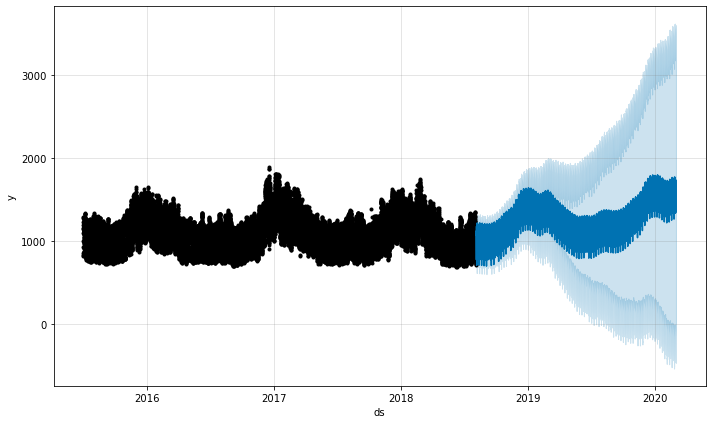

In [73]:
model.plot(forecast)
plt.show()

## Evaluate model performance

In [74]:
y_true = test_data.values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 210.607


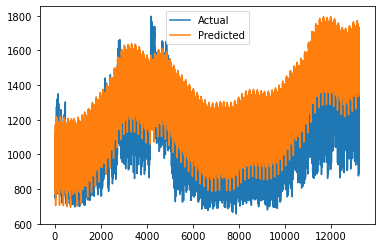

In [75]:
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()